In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

plt.style.use('fivethirtyeight')

### Starting with Lag Features

In [5]:
# import data
df = pd.read_csv('df_post_eda.csv')
df.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,day_of_week,quarter,dayofyear,dayofmonth,weekofyear,season,holidays,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
0,2023-05-10,19,NE,5481710,152400,1647380,2905630,0,283379,303944.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,NaN
1,2023-05-10,19,LA,10282120,330500,3807980,5164550,0,221178,236516.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,55.8
2,2023-05-10,19,GA,28727475,869100,9763000,14773655,0,270569,288404.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,43.3
3,2023-05-10,19,WY,1281755,49300,490040,585605,0,221466,235691.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,44.3
4,2023-05-10,19,CO,17769135,501900,5402640,9029715,0,308560,327449.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,47.3


In [6]:
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [7]:
grouped_data = df.groupby(df.index).mean()
grouped_data.head()

,MMWR_week,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,...,Additional_Doses_Unk_Manuf,month,year,quarter,dayofyear,dayofmonth,weekofyear,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,44.0,1.663188e+07,818798.4375,6.480709e+06,9.242425e+06,89947.65625,146818.062500,152028.625000,167037.250000,186038.703125,...,249.390625,11.0,2021.0,4.0,307.0,3.0,44.0,0.0,0.0,10.367188
2021-11-10,45.0,1.714537e+07,836476.5625,6.642025e+06,9.666864e+06,0.00000,151460.531250,156997.781250,173446.453125,194278.203125,...,243.156250,11.0,2021.0,4.0,314.0,10.0,45.0,1.0,0.0,13.204688
2021-11-17,46.0,1.768302e+07,853621.8750,6.841471e+06,9.987929e+06,0.00000,155606.890625,161287.484375,178169.640625,199577.812500,...,272.468750,11.0,2021.0,4.0,321.0,17.0,46.0,0.0,1.0,15.907813
2021-11-24,47.0,1.811490e+07,874050.0000,6.908257e+06,1.033259e+07,0.00000,159194.265625,165021.546875,182287.593750,204172.562500,...,310.875000,11.0,2021.0,4.0,328.0,24.0,47.0,1.0,0.0,18.985937
2021-12-01,48.0,1.822699e+07,882312.5000,6.931029e+06,1.041364e+07,0.00000,160201.109375,166069.109375,183443.203125,205459.156250,...,332.187500,12.0,2021.0,4.0,335.0,1.0,48.0,0.0,1.0,20.384375


In [10]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=grouped_data[['Additional_Doses_Vax_Pct']].join(lag1df)
    return df.fillna(0) 
df = process(grouped_data)
df.drop(columns=['lag1_Additional_Doses_Vax_Pct_1_w_lag'], inplace=True)
df.head()

,Additional_Doses_Vax_Pct,lag1_MMWR_week,lag1_Distributed,lag1_Distributed_Janssen,lag1_Distributed_Moderna,lag1_Distributed_Pfizer,lag1_Distributed_Unk_Manuf,lag1_Dist_Per_100K,lag1_Distributed_Per_100k_5Plus,lag1_Distributed_Per_100k_12Plus,...,lag1_Additional_Doses_Janssen,lag1_Additional_Doses_Unk_Manuf,lag1_month,lag1_year,lag1_quarter,lag1_dayofyear,lag1_dayofmonth,lag1_weekofyear,lag1_holiday_season,lag1_vax_announcement
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,10.332812,0.0,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-10,13.185937,44.0,1.663188e+07,818798.4375,6.480709e+06,9.242425e+06,89947.65625,146818.062500,152028.625000,167037.250000,...,4213.171875,249.390625,11.0,2021.0,4.0,307.0,3.0,44.0,0.0,0.0
2021-11-17,15.871875,45.0,1.714537e+07,836476.5625,6.642025e+06,9.666864e+06,0.00000,151460.531250,156997.781250,173446.453125,...,8073.718750,243.156250,11.0,2021.0,4.0,314.0,10.0,45.0,1.0,0.0
2021-11-24,18.675000,46.0,1.768302e+07,853621.8750,6.841471e+06,9.987929e+06,0.00000,155606.890625,161287.484375,178169.640625,...,11678.015625,272.468750,11.0,2021.0,4.0,321.0,17.0,46.0,0.0,1.0
2021-12-01,20.689062,47.0,1.811490e+07,874050.0000,6.908257e+06,1.033259e+07,0.00000,159194.265625,165021.546875,182287.593750,...,15452.343750,310.875000,11.0,2021.0,4.0,328.0,24.0,47.0,1.0,0.0


In [11]:
train_size = int(0.7 * len(df))  # 70% training data, 30% testing data
train = df[:train_size]
test = df[train_size:]

print(train.shape, test.shape) # 70-30 train split

(56, 69) (24, 69)


In [12]:
X_train, y_train = train.drop(pred_var, axis=1), train[pred_var]
X_test, y_test = test.drop(pred_var, axis=1), test[pred_var]

In [13]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:29.73758	validation_1-rmse:37.14917
[1]	validation_0-rmse:21.18850	validation_1-rmse:27.81807
[2]	validation_0-rmse:15.12733	validation_1-rmse:21.03218
[3]	validation_0-rmse:10.81395	validation_1-rmse:16.02307
[4]	validation_0-rmse:7.74733	validation_1-rmse:12.30942
[5]	validation_0-rmse:5.56035	validation_1-rmse:9.52438
[6]	validation_0-rmse:4.00278	validation_1-rmse:7.49296
[7]	validation_0-rmse:2.89945	validation_1-rmse:5.99785
[8]	validation_0-rmse:2.10779	validation_1-rmse:5.14421
[9]	validation_0-rmse:1.54622	validation_1-rmse:4.50349
[10]	validation_0-rmse:1.14782	validation_1-rmse:3.92061
[11]	validation_0-rmse:0.86709	validation_1-rmse:3.42200
[12]	validation_0-rmse:0.66235	validation_1-rmse:3.04257
[13]	validation_0-rmse:0.51874	validation_1-rmse:2.73476
[14]	validation_0-rmse:0.41112	validation_1-rmse:2.51445
[15]	validation_0-rmse:0.32769	validation_1-rmse:2.32685
[16]	validation_0-rmse:0.26834	validation_1-rmse:2.18500
[17]	validation_0-rmse:0.21545	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

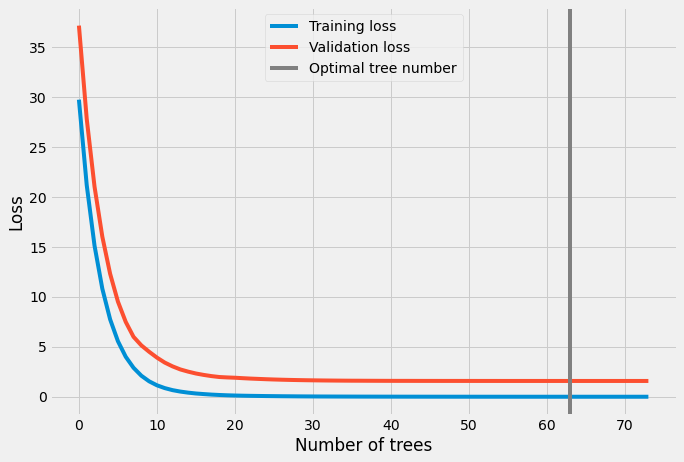

In [14]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [15]:
reg.best_iteration

63

In [20]:
test['test_prediction'] = reg.predict(X_test)
all_ = pd.concat([test, train], sort=False)
all_

,Additional_Doses_Vax_Pct,lag1_MMWR_week,lag1_Distributed,lag1_Distributed_Janssen,lag1_Distributed_Moderna,lag1_Distributed_Pfizer,lag1_Distributed_Unk_Manuf,lag1_Dist_Per_100K,lag1_Distributed_Per_100k_5Plus,lag1_Distributed_Per_100k_12Plus,...,lag1_Additional_Doses_Unk_Manuf,lag1_month,lag1_year,lag1_quarter,lag1_dayofyear,lag1_dayofmonth,lag1_weekofyear,lag1_holiday_season,lag1_vax_announcement,test_prediction
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,49.730141,47.0,2.902270e+07,9.955672e+05,1.062305e+07,1.737324e+07,0.0000,258077.625000,271872.437500,300492.265625,...,1964.187500,11.0,2022.0,4.0,327.0,23.0,47.0,0.0,0.0,49.730141
2022-12-07,49.730247,48.0,2.910561e+07,9.958172e+05,1.065100e+07,1.742772e+07,0.0000,258753.781250,272574.015625,301265.890625,...,1977.328125,11.0,2022.0,4.0,334.0,30.0,48.0,0.0,0.0,49.730247
2022-12-14,49.730076,49.0,2.926282e+07,9.960203e+05,1.069705e+07,1.753824e+07,0.0000,260253.343750,274146.843750,303005.546875,...,2011.000000,12.0,2022.0,4.0,341.0,7.0,49.0,0.0,1.0,49.730076
2022-12-21,49.735107,50.0,2.942324e+07,9.963172e+05,1.074550e+07,1.764912e+07,153.1250,261687.062500,275647.562500,304664.296875,...,2039.609375,12.0,2022.0,4.0,348.0,14.0,50.0,0.0,1.0,49.735107
2022-12-28,49.734543,51.0,2.961061e+07,9.965453e+05,1.081126e+07,1.773696e+07,33210.9375,263413.515625,277465.328125,306675.562500,...,2064.625000,12.0,2022.0,4.0,355.0,21.0,51.0,0.0,0.0,49.734543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-26,49.037500,42.0,2.789017e+07,9.940766e+05,1.024045e+07,1.662773e+07,0.0000,247634.515625,260901.984375,288376.093750,...,1699.984375,10.0,2022.0,4.0,292.0,19.0,42.0,0.0,1.0,NaN
2022-11-02,49.237500,43.0,2.814254e+07,9.943906e+05,1.032572e+07,1.679391e+07,0.0000,250015.281250,263399.062500,291144.734375,...,1724.781250,10.0,2022.0,4.0,299.0,26.0,43.0,0.0,0.0,NaN
2022-11-09,49.409375,44.0,2.932765e+07,1.029853e+06,1.078875e+07,1.747860e+07,0.0000,258946.234375,272736.203125,301402.234375,...,1748.546875,11.0,2022.0,4.0,306.0,2.0,44.0,0.0,0.0,NaN


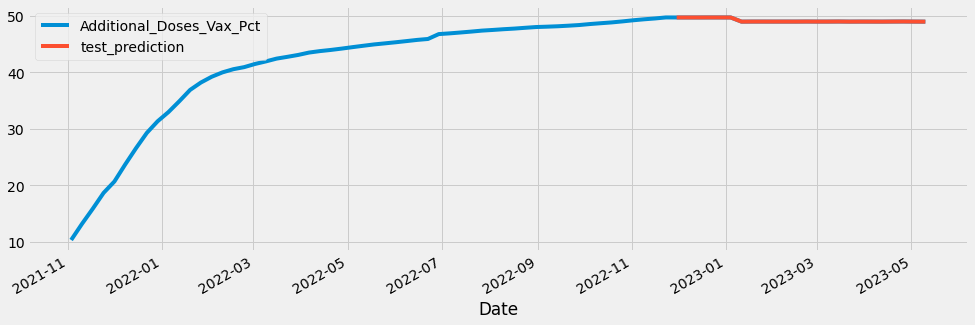

In [22]:
_ = all_[[pred_var,'test_prediction']].plot(figsize=(15, 5))